In [5]:
import time
import csv
import serial
import numpy as np

def motor(dis,status,file):
    ser = serial.Serial('COM8', 115200, timeout=1)
    ser_bytes = ser.readline()
    ser.flushInput()
    to=time.perf_counter()
    cmd=str(dis)
    cmd2=cmd
    if status == True:
        cmd2='-'+ cmd
    count2=0
    ser.write(cmd2.encode('UTF-8')+ b"\n")
    
    if status == False:
        with open("test_data_"+file+"_.csv","a") as f:
            writer = csv.writer(f,delimiter=";",lineterminator='\r')
            writer.writerow(['time','motor_revolutions','sensor_value','Distance_mm','Force_N'])


    while count2<=dis*10:    #10 PULSES IS 1 CM
            count2=count2+1
            ser_bytes = ser.readline()
            decoded_bytes = ser_bytes.decode()
            if len(decoded_bytes)>0 :
                decoded_bytes=decoded_bytes.strip()
                separated_data=decoded_bytes.split(",")
                integer_data = [i for i in separated_data]
                integer_array= np.array(integer_data)
                #print(integer_array)
                
                if status == True:
                    distance=((dis*800)-(int(integer_array[0])+1))/800  #1 mm = 800 pulses
                else :
                    distance=(int(integer_array[0])+1)/800  #1 mm = 800 pulses
                    
                force= (11*(int(integer_array[1]))-77)  #The force is sent on Newtons*1000 *9,8
                
                
                
                with open("test_data_"+file+"_.csv","a") as f:
                        writer = csv.writer(f,delimiter=";",lineterminator='\r')
                        writer.writerow([time.perf_counter()-to,integer_array[0],integer_array[1],distance, force])
           
    f.close()
    ser.close()
    
def plotting():
        df = pd.read_csv("test_data_"+text4.value+"_.csv",delimiter=';')
        #Filtering
        b, a = signal.butter(3, 0.05)
        filter_force = signal.filtfilt(b, a, df['Force_N'])
        df = df.assign(Filtered_Force=filter_force/(9.8*10000))
        
        ## Calculating stress
        area= float(text2.value)*float(text3.value)/(1000*1000)    #width*thickness
        stress=df['Filtered_Force']/area
        strain=((df['Distance_mm'])/float(text1.value))
        df = df.assign(Tensile_stress_Nm_2=stress)
        df = df.assign(Longitudinal_strain=strain)

        df.plot(y='Filtered_Force')
        df.plot(x='Distance_mm', y='Filtered_Force')
        df.plot(x='Longitudinal_strain', y=['Tensile_stress_Nm_2'])  
        df.to_csv("processed_data_"+text4.value+"_.csv")

In [6]:
# some handy functions to use along widgets
from IPython.display import display, Markdown, clear_output
# widget packages
import ipywidgets as widgets
# defining some widgets

import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt


layout = widgets.Layout(width='auto', height='40px') #set width and height

text1 = widgets.Text(
       #value='Introduce the initial length of the material',
       value='',
       description='Length [mm]',
       placeholder="Introduce the initial length of the material in mm",
       display='flex',)

text2 = widgets.Text(
       value='',
       description='Width [mm]', )

text3 = widgets.Text(
       value='',
       description='Thickn. [mm]',
       display='flex',
       flex_flow='column',
       align_items='stretch',)

text4 = widgets.Text(
       value='',
       description='File name',
       display='flex',
       flex_flow='column',
       align_items='stretch',)


calendar = widgets.DatePicker(
           description='Select Date')
slider = widgets.FloatSlider(
         value=1,
         min=0,
         max=150.0,
         step=5,
         description='Distance')
menu = widgets.Dropdown(
       options=['red', 'blue', 'green'],
       value='red',
       description='Color:')
checkbox = widgets.Checkbox(
           description='Reverse Direction',)

button = widgets.Button(description='Run')
out = widgets.Output()

button2 = widgets.Button(description='Plot')
out2 = widgets.Output()

def on_button_clicked(_):
      # "linking function with output"
    with out:
          # what happens when we press the button
        clear_output()
        motor(int(slider.value),checkbox.value,text4.value)
        #print(int(slider.value))
        time.sleep(1)
        motor(int(slider.value),not checkbox.value,text4.value)
        #print(int(slider.value))
        plotting()
        
def on_button_clicked2(_):
    # "linking function with output"
    plotting()

# Mechanical Stress
- Write down the dimensions of the material. $l$ (length), $w$ (width), and $t$ (thickness).

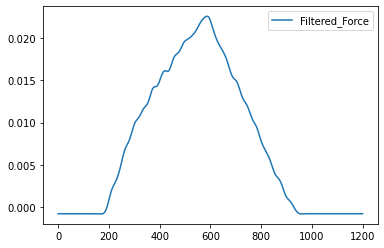

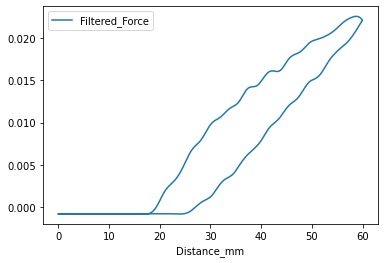

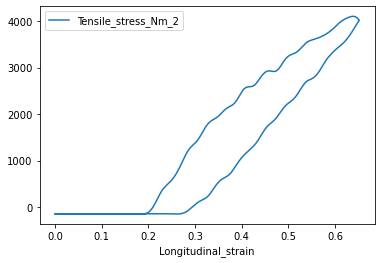

In [7]:
button.on_click(on_button_clicked)
button2.on_click(on_button_clicked2)
buttonbox=widgets.HBox([button])
grapher2=widgets.VBox([text1, text2, text3, text4, checkbox, slider, buttonbox,out])

info = Markdown("""# Mechanical Stress
- Write down the dimensions of the material. $l$ (length), $w$ (width), and $t$ (thickness).""")
display(info, grapher2)